D606 - Data Science Capstone  
EBN2 — EBN2 Task 2: Data Analysis Report  
Logistic Regression Analysis of Adolescent Suicidal Ideation  
John D. Pickering

### Data Import
- Import Exported .csv files for YBRS 2023
- Convert multi-point answers to binary
- Data File
  - yrbs2023.csv
- Support Files
    - IndenpendentVariables.xlsx
    - 05_race.csv
    - 04_grade.csv
    - 02_age.csv
   

In [1]:
# Import Dependencies

import pandas as pd
from pathlib import Path
import re
import fitz  # PyMuPDF
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency

In [2]:
# Import Data and mapping files.

def load_and_prepare_yrbs(mapping_path, data_path):
    """
    Load mapping + data file, select fields, rename them, 
    and apply 0/1 conversion for multi-select variables only.
    """

    # -----------------------------
    # Load files
    # -----------------------------
    mapping = pd.read_csv(mapping_path, low_memory=False)
    df = pd.read_csv(data_path, low_memory=False)

    # Normalize fields for safe comparisons
    mapping["type"] = mapping["type"].astype(str).str.lower()
    mapping["variable_type"] = mapping["variable_type"].astype(str).str.lower()


    # Keep only mapping rows where dataset contains the column

    mapping_valid = mapping[mapping["column"].isin(df.columns)].copy()


    # Create subset dataframe + rename using variable_label

    rename_dict = dict(zip(mapping_valid["column"], mapping_valid["variable_label"]))
    df = df[mapping_valid["column"]].rename(columns=rename_dict)


    # Convert multi-select variables to 0/1

    for _, row in mapping_valid.iterrows():

        label = row["variable_label"]
        convert_id = row["convert_id"]
        type_ = row["type"]
        var_type = row["variable_type"]

        # Only convert multi-select, non-demographic rows
        if type_ == "multi-select" and var_type != "demographic":

            # Must have a threshold
            if pd.isna(convert_id):
                continue

            # Make sure values are numeric
            df[label] = pd.to_numeric(df[label], errors="coerce").fillna(0)

            # Apply threshold rule
            df[label] = (df[label] >= convert_id).astype(int)

    return df, mapping_valid

In [3]:
# Run load_and_prepare_yrbs
mapping_file = "2023_indenpendent_variables.csv"
data_file = "yrbs2023.csv"   # adjust path if needed

df_2023, mapping = load_and_prepare_yrbs(mapping_file, data_file)
print('Mapping Complete')

Mapping Complete


In [4]:
# Identify binary, non-demographic variables from mapping ---
binary_vars = (
    mapping[
        (mapping["type"].str.lower() == "binary") &
        (mapping["variable_type"].str.lower() != "demographic")
    ]["variable_label"]
    .tolist()
)

print("Binary variables to convert:", binary_vars)

# --- Convert 1→1 and 2→0 in df_2023 ---
for col in binary_vars:
    if col in df_2023.columns:
        df_2023[col] = df_2023[col].replace({1: 1, 2: 0})


Binary variables to convert: ['considered suicide', 'saw physical violence in neighborhood', 'forced sexual intercourse', 'bullying at school', 'electronic bullying', 'sad or hopeless', 'made a suicide plan', 'ever cigarette use', 'electronic vapor product use', 'ever sexual intercourse']


In [5]:
# convert all to Int64 for Analysis
df_2023[binary_vars] = df_2023[binary_vars].astype("Int64")

In [6]:

# IDENTIFY DEMOGRAPHIC LABELS

demo_labels = (
    mapping[mapping["variable_type"].str.lower() == "demographic"]["variable_label"]
    .str.strip()
    .str.lower()
    # .str.replace(" ", "_")
    .tolist()
)

print("Demographic labels:", demo_labels)


# EXTRACT DEMOGRAPHIC COLUMNS

df_demo = df_2023[[label for label in demo_labels if label in df_2023.columns]].copy()

Demographic labels: ['how old are you', 'what is your sex', 'in what grade are you', 'what is your race']


In [7]:
# Download data to preserve formatting and save for future use. 
print('Download Data file for future use')
df_2023.to_csv("df_2023_cleaned.csv")

Download Data file for future use


In [8]:

# Load lookup tables

age_lookup = pd.read_csv("02_age.csv")
grade_lookup = pd.read_csv("04_grade.csv")
race_lookup = pd.read_csv("05_race.csv", encoding="latin1")
# Make lookup dictionaries
age_map = dict(zip(age_lookup["ID"], age_lookup["Description"]))
grade_map = dict(zip(grade_lookup["ID"], grade_lookup["Description"]))
race_map = dict(zip(race_lookup["ID"], race_lookup["Description"]))


# Apply mappings to demographic columns

# Replace raw codes with text labels
if "how old are you" in df_demo.columns:
    df_demo["age_label"] = df_demo["how old are you"].map(age_map)

if "in what grade are you" in df_demo.columns:
    df_demo["grade_label"] = df_demo["in what grade are you"].map(grade_map)

if "what is your race" in df_demo.columns:
    df_demo["race_label"] = df_demo["what is your race"].map(race_map)


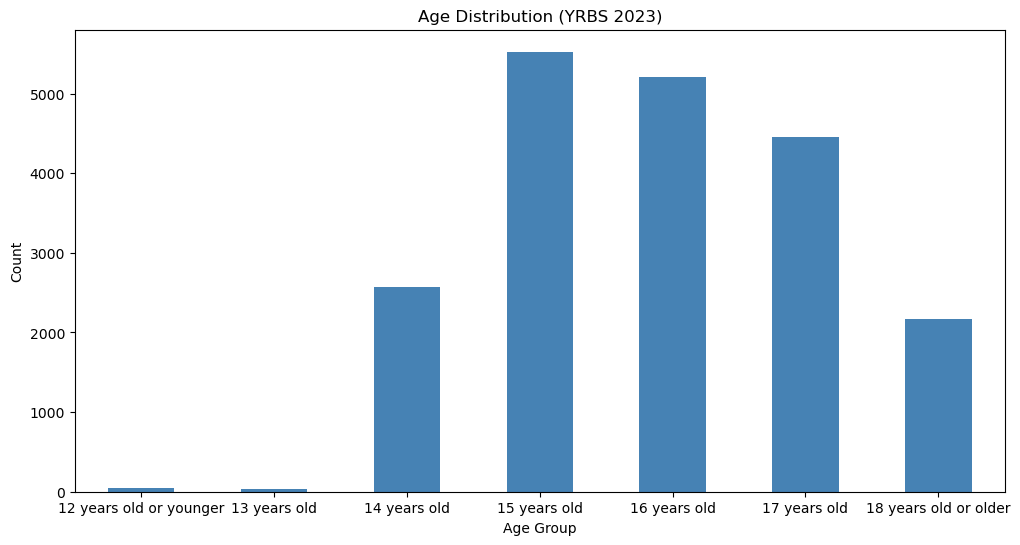

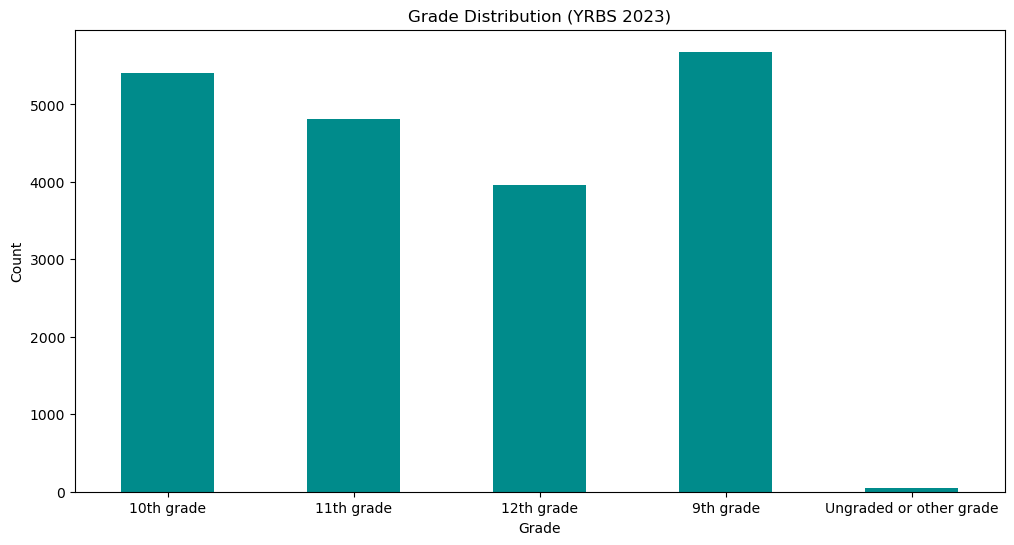

/tmp/ipykernel_18538/678133816.py:31: UserWarning: Glyph 150 (\x96) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/jdpic/miniconda3/envs/shap_env_new/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 150 (\x96) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


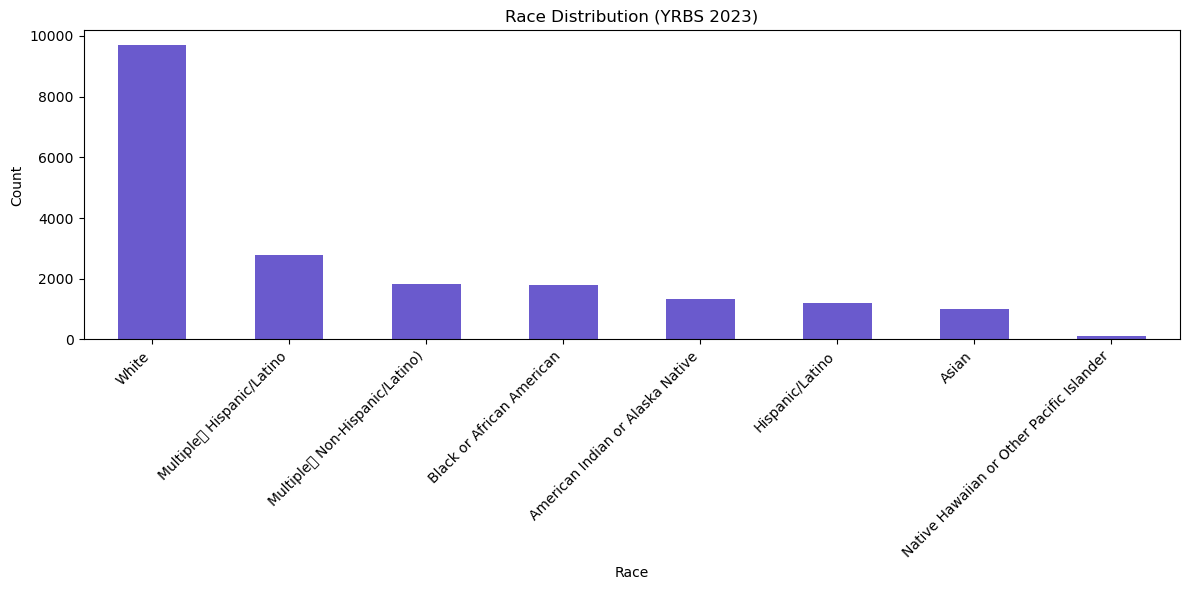

In [9]:
# Create demographic visuals

# AGE
if "age_label" in df_demo.columns:
    plt.figure(figsize=(12,6))
    df_demo["age_label"].value_counts().sort_index().plot(kind="bar", color="steelblue")
    plt.title("Age Distribution (YRBS 2023)")
    plt.xlabel("Age Group")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.show()

# GRADE
if "grade_label" in df_demo.columns:
    plt.figure(figsize=(12,6))
    df_demo["grade_label"].value_counts().sort_index().plot(kind="bar", color="darkcyan")
    plt.title("Grade Distribution (YRBS 2023)")
    plt.xlabel("Grade")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.show()

# RACE
if "race_label" in df_demo.columns:
    plt.figure(figsize=(12,6))
    df_demo["race_label"].value_counts().plot(kind="bar", color="slateblue")
    plt.title("Race Distribution (YRBS 2023)")
    plt.xlabel("Race")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


#### Demographic Overview of the YRBS data.  
The YRBS dataset offers a large, diverse sample of U.S. high school students, providing a broad and representative view of student characteristics across various demographic dimensions.

#### Age
The age distribution shows a typical spread among high school students. Most respondents are between 15 and 17 years old, with fewer students in the youngest and oldest age groups. This pattern aligns with the typical age range for high school students and indicates a good representation of students across grade levels. This pattern aligns with the modal high school age range and suggests adequate representation of students across grade levels.  

#### Sex
The sample is nearly evenly divided between female and male respondents. This near-parity supports balanced comparisons across sex-based analyses and reduces concerns about sex-related sampling bias.

#### Grade
Students in grades 9 through 12 are well represented in the dataset, with each grade contributing significant portions. The distribution is relatively balanced, with no single grade dominating the sample. A small number of respondents were classified as "ungraded or other," a pattern typical of YRBS datasets. A minimal number of respondents were classified as "ungraded or other grade," which is expected for YRBS datasets.

#### Race & Ethnicity
The dataset comprises students from a variety of racial and ethnic backgrounds. The largest group identifies as White, followed by significant representation from Black or African American, Hispanic/Latino, and Multiracial categories. Smaller yet important groups include Asian, American Indian or Alaska Native, and Native Hawaiian or Other Pacific Islander students. This diversity allows for the analysis of outcomes across different racial and ethnic subgroups; however, smaller categories should be interpreted with caution due to their lower sample sizes.

In [10]:
#### Logistic Regression models
# Make a working copy
df = df_2023.copy()

# Depenedent variable
outcome = "considered suicide"

# Add Select variables (predictors)
predictors = [
    "sad or hopeless",
    "electronic bullying",
    "bullying at school",
    "treated badly because of race or ethnicity",
    "forced sexual intercourse",
    "current binge drinking",
    "ever marijuana use",
    "ever cigarette use",
    "ever prescription pain medicine use",
    "what is your sex",
    "how old are you",
    "ever sexual intercourse",
    "saw physical violence in neighborhood",
    "ever heroin use",
    "ever use cocaine",
    "weapon carrying at school",
    "safety concerns at school"
]



# Build modeling dataframe
model_df = df[[outcome] + predictors].dropna()

# Convert predictors + outcome to float
for col in predictors + [outcome]:
    model_df[col] = pd.to_numeric(model_df[col], errors="coerce").astype(float)


# Set up X and y
X = model_df[predictors]
y = model_df[outcome]

# Add intercept
X = sm.add_constant(X)


# Fit logistic regression
logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())


# Compute Odds Ratios
odds_ratios = pd.DataFrame({
    "Variable": X.columns,
    "Odds Ratio": np.exp(result.params),
    "p-value": result.pvalues
})

print("\nOdds Ratios:")
print(odds_ratios)


Optimization terminated successfully.
         Current function value: 0.372123
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:     considered suicide   No. Observations:                11062
Model:                          Logit   Df Residuals:                    11044
Method:                           MLE   Df Model:                           17
Date:                Sat, 29 Nov 2025   Pseudo R-squ.:                  0.3044
Time:                        14:16:29   Log-Likelihood:                -4116.4
converged:                       True   LL-Null:                       -5917.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                       

#### Logistic Regression Results
A binary logistic regression model was estimated to examine which behavioral, environmental, and demographic factors were associated with the likelihood of adolescents considering suicide. The model included variables related to mental health status, bullying, violence, substance use, weapon carrying, neighborhood safety, and demographics. The final model contained 17 predictors and was statistically significant overall (LLR p < .001), indicating that the set of predictors reliably distinguishes between students who did and did not consider suicide.

The model demonstrated a Pseudo R² of 0.3044, suggesting that approximately 30% of the variability in suicidal ideation is explained by the included predictors—strong performance for a behavioral health model based on survey data.

Overall the strongest predictors of suicidal ideation were
- Sad or hopeless
- Forced Sexual Intercourse
- Substance use (marijuana, cigarettes, prescription pain medication)
- Bullying (electronic and in-school)
- Exposure to neighborhood violence
- Weapon carrying at school

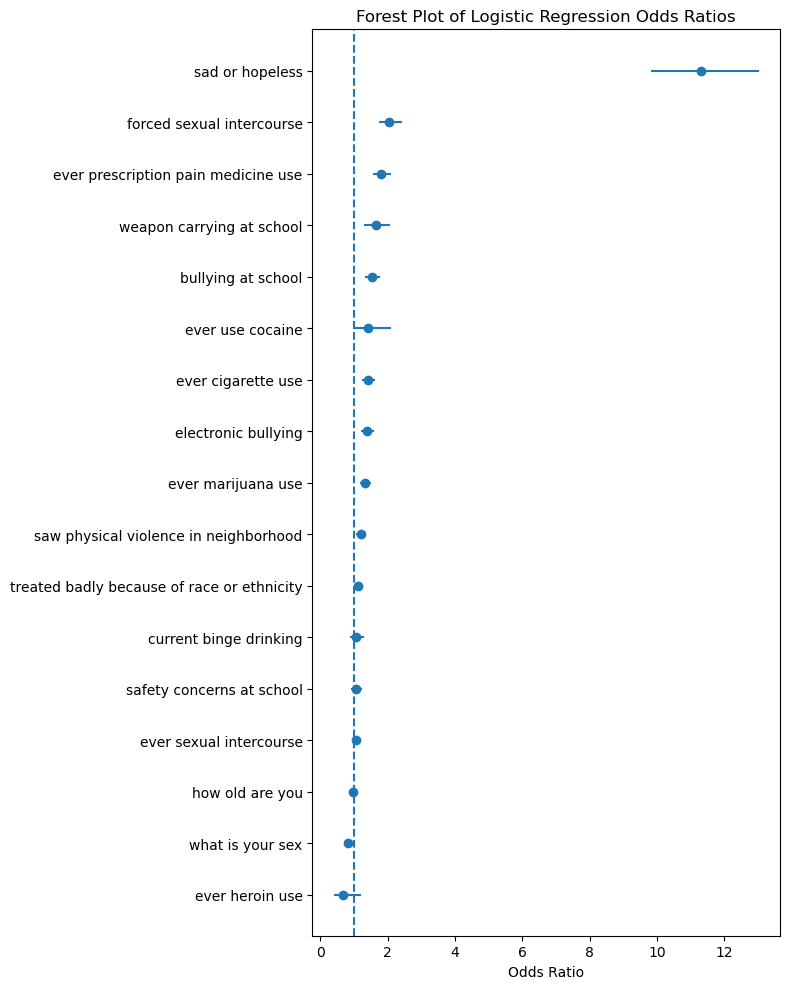

In [11]:
#import matplotlib.pyplot as plt
#import numpy as np

# Extract coefficients and CI from the model
params = result.params
conf = result.conf_int()
conf['OR'] = np.exp(params)
conf.columns = ['2.5%', '97.5%', 'OR']

# Drop the intercept
conf = conf.drop("const")

# Sort by odds ratio (optional, looks cleaner)
conf = conf.sort_values("OR")

# Plot
plt.figure(figsize=(8, 10))

y_pos = range(len(conf))

plt.errorbar(
    conf["OR"], 
    y_pos, 
    xerr=[conf["OR"] - np.exp(conf["2.5%"]), np.exp(conf["97.5%"]) - conf["OR"]],
    fmt='o'
)

plt.yticks(y_pos, conf.index)
plt.axvline(x=1, linestyle='--')  # reference line at OR=1
plt.xlabel("Odds Ratio")
plt.title("Forest Plot of Logistic Regression Odds Ratios")
plt.tight_layout()
plt.show()

The forest plot illustrates the odds ratios derived from the logistic regression model, highlighting the strength and direction of each predictor's relationship with suicidal ideation. Points located to the right of the vertical reference line (OR = 1) indicate an increased likelihood of considering suicide, while points near or to the left of the line suggest little or no effect.

The most influential predictor is the experience of feeling sad or hopeless, which has an odds ratio greater than 11. This means that students who report persistent sadness are significantly more likely to consider suicide. Other strong predictors include experiences of forced sexual intercourse, misuse of prescription pain medication, carrying weapons at school, bullying (both in-person and online), and marijuana use.

On the other hand, predictors that are close to the reference line, such as binge drinking, safety concerns at school, sexual intercourse, age, and sex, exhibit relatively small or nonsignificant effects when controlling for all other variables. Overall, the plot visually emphasizes which factors most significantly contribute to suicidal ideation in the model.

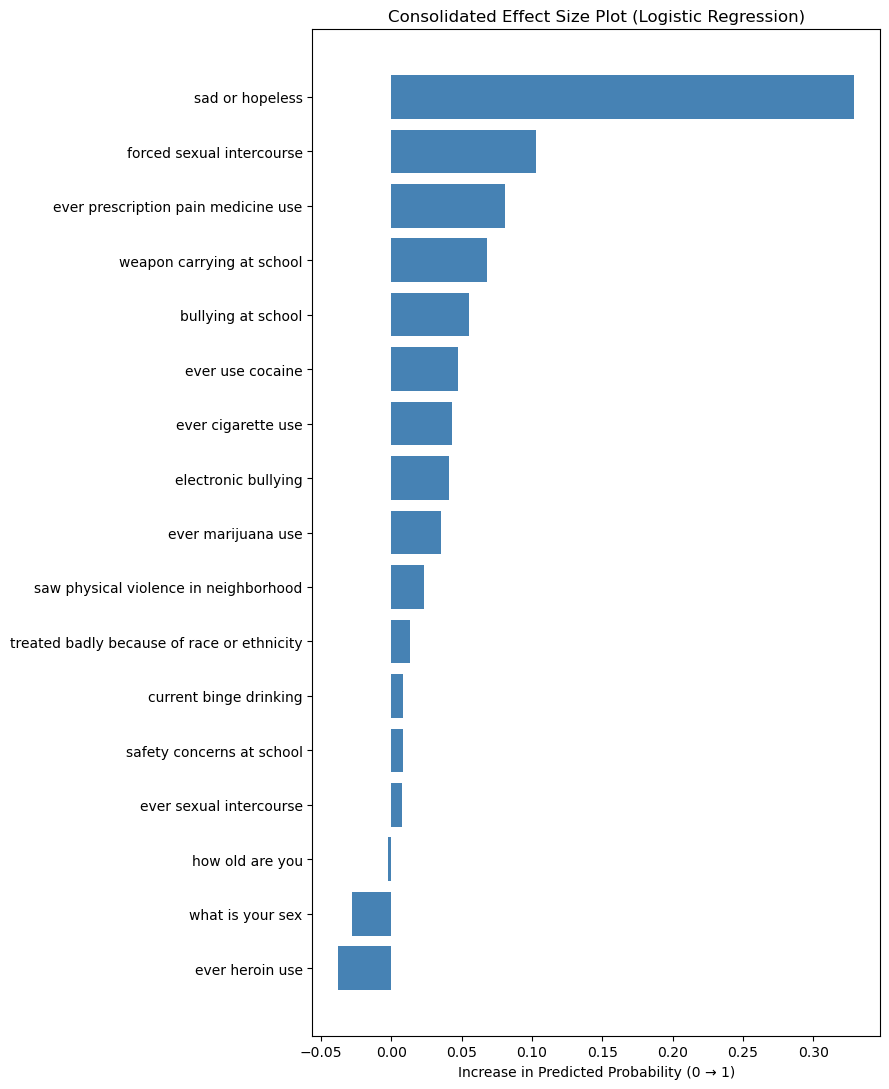

In [12]:
# consolidated effect-size plot
#import pandas as pd
#import numpy as np
#mport matplotlib.pyplot as plt

# LOAD FINAL CLEANED DATASET

df = pd.read_csv("df_2023_cleaned.csv")


# 2. FIX OUTCOME VALUES (THE KEY STEP)

df["considered suicide"] = pd.to_numeric(df["considered suicide"], errors="coerce")
df["considered suicide"] = df["considered suicide"].replace({2: 0})
df = df[df["considered suicide"].isin([0, 1])]   # keep only valid values


# 3. DEFINE OUTCOME + PREDICTORS
outcome = "considered suicide"

predictors =  [
    "sad or hopeless",
    "electronic bullying",
    "bullying at school",
    "treated badly because of race or ethnicity",
    "forced sexual intercourse",
    "current binge drinking",
    "ever marijuana use",
    "ever cigarette use",
    "ever prescription pain medicine use",
    "what is your sex",
    "how old are you",
    "ever sexual intercourse",
    "saw physical violence in neighborhood",
    "ever heroin use",
    "ever use cocaine",
    "weapon carrying at school",
    "safety concerns at school"
]

# CLEAN NUMERIC + DROP MISSING
model_df = df[predictors + [outcome]].apply(pd.to_numeric, errors="coerce").dropna()

X = model_df[predictors]
y = model_df[outcome]

# Add intercept
X = sm.add_constant(X)


# FIT LOGISTIC REGRESSION
logit_model = sm.Logit(y, X)
result = logit_model.fit(disp=False)


# CALCULATE EFFECT SIZES
effect_sizes = []
baseline = X.mean().to_dict()

for var in predictors:
    scenario0 = baseline.copy()
    scenario1 = baseline.copy()
    scenario0[var] = 0
    scenario1[var] = 1

    p0 = result.predict(pd.DataFrame([scenario0]))[0]
    p1 = result.predict(pd.DataFrame([scenario1]))[0]

    effect_sizes.append([var, p1 - p0])

effect_df = pd.DataFrame(effect_sizes, columns=["Predictor", "Effect Size"])
effect_df = effect_df.sort_values("Effect Size", ascending=False)


# PLOT CONSOLIDATED EFFECT SIZES

plt.figure(figsize=(9, 11))
plt.barh(effect_df["Predictor"], effect_df["Effect Size"], color="steelblue")
plt.xlabel("Increase in Predicted Probability (0 → 1)")
plt.title("Consolidated Effect Size Plot (Logistic Regression)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# effect_df


The consolidated effect-size plot illustrates how each predictor influences the likelihood that a student has considered suicide, based on the logistic regression model. Each bar represents the change in predicted probability when a variable shifts from 0 to 1, while keeping all other factors constant. The results reveal an uneven distribution of influence: feeling sad or hopeless is the strongest predictor, increasing the probability of suicidal thoughts by over 30 percentage points. Other significant factors, such as experiencing forced sexual intercourse, misusing prescription pain medication, carrying a weapon at school, and various substance-use behaviors, also show notable effects, though they are comparatively smaller. Lower-ranked predictors, including heroin use, sex, and current binge drinking, contribute very little or have almost no impact after controlling for the entire set of variables. Overall, this plot provides a clear visual summary of which risk factors have the most significant independent effects in the model and allows for easy comparison across all predictors in a single figure.

In [13]:
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
#import statsmodels.api as sm

df_work = df.copy()

# Extract predictors used in the model
model_predictors = result.model.exog_names.copy()
model_predictors.remove("const")

# Identify binary predictors
binary_predictors = [
    p for p in model_predictors
    if df_work[p].dropna().nunique() == 2
]

def scenario_predictions_with_ci(df, model, predictor, sims=2000):
    """
    Compute predicted probabilities for predictor=0 and predictor=1
    plus 95% CI using simulation from coefficient covariance.
    """

    predictors = model.model.exog_names.copy()
    predictors.remove("const")

    base = df[predictors].mean()

    s0 = base.copy()
    s1 = base.copy()
    s0[predictor] = 0
    s1[predictor] = 1

    # Build prediction matrix
    X_new = pd.DataFrame([s0, s1], columns=predictors)
    X_new = sm.add_constant(X_new, has_constant="add")

    # Point estimates
    pred_point = model.predict(X_new)

    # Simulate coefficients
    coef_samples = np.random.multivariate_normal(
        mean=model.params,
        cov=model.cov_params(),
        size=sims
    )

    # Compute simulated probabilities
    sim_probs = 1 / (1 + np.exp(-(X_new.values @ coef_samples.T)))

    # Extract CI
    lower = sim_probs.T[:, 0], sim_probs.T[:, 1]
    upper = lower

    ci_0 = (np.percentile(sim_probs[0, :], 2.5), np.percentile(sim_probs[0, :], 97.5))
    ci_1 = (np.percentile(sim_probs[1, :], 2.5), np.percentile(sim_probs[1, :], 97.5))

    return (
        pred_point[0], ci_0,
        pred_point[1], ci_1,
        pred_point[1] - pred_point[0]
    )

# Build effect size table
rows = []

for predictor in binary_predictors:
    p0, ci0, p1, ci1, eff = scenario_predictions_with_ci(df_work, result, predictor)
    rows.append([predictor, p0, ci0, p1, ci1, eff])

effect_table_ci = pd.DataFrame(rows, columns=[
    "Predictor",
    "Prob_0",
    "CI_0",
    "Prob_1",
    "CI_1",
    "Effect Size"
])

effect_table_ci["Rank"] = effect_table_ci["Effect Size"].rank(ascending=False).astype(int)
effect_table_ci = effect_table_ci.sort_values("Effect Size", ascending=False)
effect_table_ci.reset_index(drop=True, inplace=True)

effect_table_ci


def format_ci(ci_tuple):
    """Format CI tuple (lower, upper) to (0.xxx, 0.xxx)."""
    return f"({ci_tuple[0]:.3f}, {ci_tuple[1]:.3f})"

# Make a copy to avoid modifying original
formatted_table = effect_table_ci.copy()

formatted_table["Prob_0"] = formatted_table["Prob_0"].apply(lambda x: f"{x:.3f}")
formatted_table["Prob_1"] = formatted_table["Prob_1"].apply(lambda x: f"{x:.3f}")
formatted_table["Effect Size"] = formatted_table["Effect Size"].apply(lambda x: f"{x:.3f}")

formatted_table["CI_0"] = formatted_table["CI_0"].apply(format_ci)
formatted_table["CI_1"] = formatted_table["CI_1"].apply(format_ci)

formatted_table

,Predictor,Prob_0,CI_0,Prob_1,CI_1,Effect Size,Rank
0,sad or hopeless,0.050,"(0.045, 0.056)",0.373,"(0.356, 0.390)",0.323,1
1,forced sexual intercourse,0.116,"(0.109, 0.125)",0.213,"(0.187, 0.243)",0.097,2
2,ever prescription pain medicine use,0.116,"(0.109, 0.125)",0.192,"(0.170, 0.217)",0.076,3
3,weapon carrying at school,0.122,"(0.113, 0.130)",0.186,"(0.155, 0.223)",0.064,4
4,bullying at school,0.115,"(0.106, 0.123)",0.166,"(0.149, 0.185)",0.051,5
5,ever use cocaine,0.123,"(0.115, 0.132)",0.167,"(0.119, 0.226)",0.044,6
6,ever cigarette use,0.117,"(0.109, 0.126)",0.158,"(0.139, 0.177)",0.041,7
7,electronic bullying,0.118,"(0.110, 0.127)",0.156,"(0.138, 0.176)",0.038,8
8,ever marijuana use,0.116,"(0.107, 0.124)",0.149,"(0.135, 0.164)",0.033,9
9,saw physical violence in neighborhood,0.119,"(0.110, 0.128)",0.140,"(0.127, 0.155)",0.021,10


The table above illustrates how each binary predictor influences the predicted probability of considering suicide, based on the fitted logistic regression model. For each variable, the model estimates the probability of suicidal ideation when the predictor is set to 0 (indicating the absence of the risk factor) or 1 (indicating its presence), while keeping all other variables at their average values. The effect size indicates the difference between these probabilities, providing a precise measure of practical impact.

As anticipated, feelings of sadness or hopelessness have the most significant impact, increasing the likelihood of contemplating suicide by approximately 32 percentage points. Several other factors also contribute notably to this risk, including experiences of forced sexual intercourse, misuse of prescription pain medications, carrying weapons at school, and being bullied. In contrast, variables lower on the list, such as sex, heroin use, and having ever engaged in sexual intercourse, show minimal or even negative effects once the model accounts for all other factors.

The 95% confidence intervals provide a sense of uncertainty around each probability estimate, but the relative ordering of effect sizes remains clear. Overall, this table highlights which risk factors exert the strongest influence on suicidal ideation in the 2023 YRBS dataset.

In [14]:
# Run VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,feature,VIF
0,const,31.163228
1,sad or hopeless,1.312553
2,electronic bullying,1.451610
3,bullying at school,1.425872
4,treated badly because of race or ethnicity,1.107621
5,forced sexual intercourse,1.221907
6,current binge drinking,1.205511
7,ever marijuana use,1.454162
8,ever cigarette use,1.375644
9,ever prescription pain medicine use,1.139885


The VIF (Variance Inflation Factor) table assesses multicollinearity among the predictors in the logistic regress Overall, the VIF analysis suggests that multicollinearity is not a significant concern.

In [15]:
# Random Forest model

X = model_df[predictors]
y = model_df[outcome]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

# Feature importance
importances = pd.DataFrame({
    "feature": predictors,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

print(importances)

                                       feature  importance
0                              sad or hopeless    0.246900
10                             how old are you    0.164972
4                    forced sexual intercourse    0.054038
1                          electronic bullying    0.052323
3   treated badly because of race or ethnicity    0.050692
9                             what is your sex    0.047560
6                           ever marijuana use    0.046811
2                           bullying at school    0.046673
12       saw physical violence in neighborhood    0.045921
11                     ever sexual intercourse    0.044856
7                           ever cigarette use    0.044136
16                   safety concerns at school    0.042917
8          ever prescription pain medicine use    0.040332
5                       current binge drinking    0.032184
15                   weapon carrying at school    0.023358
14                            ever use cocaine    0.0116

The Random Forest model offers a non-linear, ensemble-based approach to determine which predictors are most significant in identifying students who have contemplated suicide. Similar to the findings from the logistic regression model, feelings of sadness or hopelessness emerge as the most crucial predictor, with an importance score more than twice that of any other variable. Additionally, the model reveals several other important factors, including experiences of forced sexual intercourse, electronic bullying, racial discrimination, marijuana use, and bullying at school, all of which contribute meaningfully to this predictive analysis.sad or hopeless is by far the strongest predictor, with an importance score more than twice that of any other variable. The model also highlights several additional factors, including forced sexual intercourse, electronic bullying, racial discrimination, marijuana use, and bullying at school, as meaningful contributors to the prediction task.

One significant difference from the logistic regression model is the greater importance of age, which ranks second among predictors in the Random Forest analysis. This indicates that age may have a non-linear or interaction-based relationship with suicidal ideation that isn't fully captured by the logistic regression framework. Additionally, several environmental and behavioral risk factors, such as exposure to neighborhood violence and cigarette use, also show moderate importance.

At the bottom of the list, lifetime use of cocaine and heroin shows minimal significance, suggesting that these behaviors contribute little to the prediction when other risk factors are considered. Overall, the Random Forest model supports the findings from logistic regression and offers additional insights into potential nonlinear relationships.

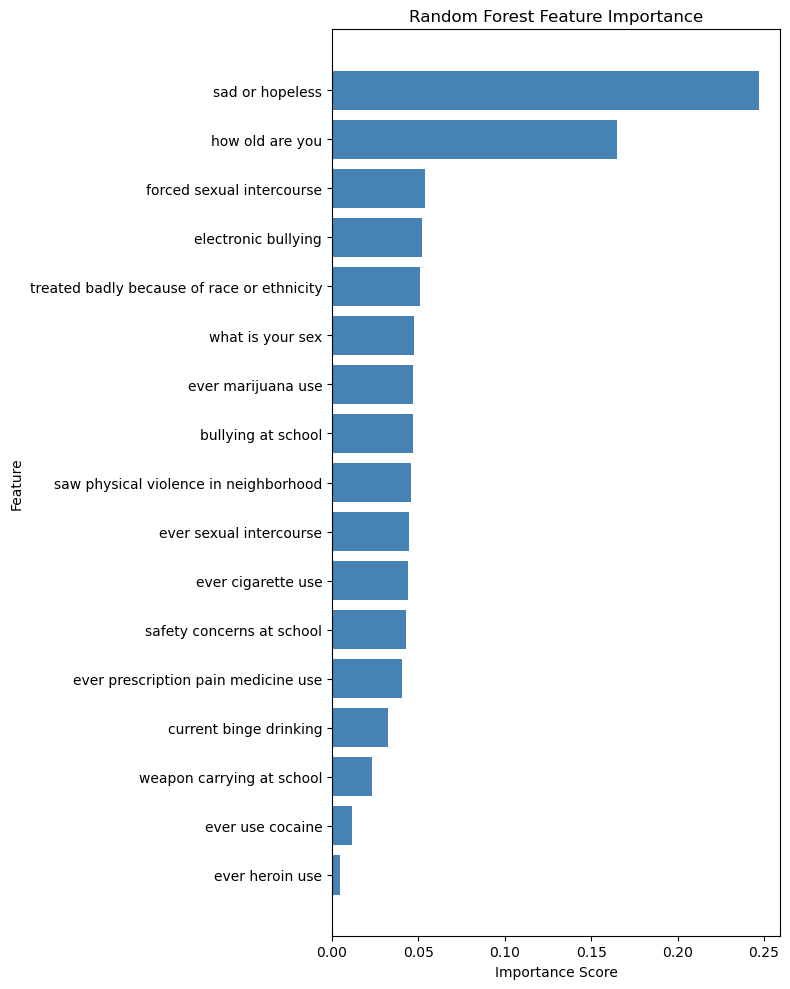

In [16]:
# Random Forest Visual

# Sort features by importance
rf_sorted = importances.sort_values("importance", ascending=True)

plt.figure(figsize=(8, 10))
plt.barh(rf_sorted["feature"], rf_sorted["importance"], color="steelblue")
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

The Random Forest model identifies sad or hopeless as the strongest predictor of whether a student considered suicide, carrying substantially more importance than any other variable. Other influential predictors include forced sexual intercourse, ever marijuana use, bullying at school, electronic bullying, and treated badly because of race or ethnicity. Although the magnitudes are smaller than the leading factor, these features still meaningfully contribute to the model's predictive performance. Lower-importance variables — such as ever heroin use, ever use cocaine, and weapon carrying at school — have relatively little influence in tree-based decision splits. Overall, the Random Forest importance rankings align closely with the logistic regression effect sizes, reinforcing the consistency of these findings across modeling techniques.

In [17]:
# Run chi-square

# Ensure predictors are numeric/categorical

df_chi = df.copy()

for col in predictors:
    df_chi[col] = pd.to_numeric(df_chi[col], errors="coerce")

df_chi["considered suicide"] = pd.to_numeric(df_chi["considered suicide"], errors="coerce")

# Drop any rows with missing predictor or outcome
df_chi = df_chi.dropna(subset=predictors + ["considered suicide"])


# Run chi-square tests for all predictors

results = []

for col in predictors:
    ct = pd.crosstab(df_chi[col], df_chi["considered suicide"])
    
    # Must have at least a 2x2 table
    if ct.shape[0] > 1:
        chi2, p, dof, exp = chi2_contingency(ct)
        results.append([col, chi2, p])
    else:
        results.append([col, None, None])


# Build formatted summary table

chi_summary = pd.DataFrame(results, columns=["Variable", "Chi-square", "p-value"])

# Format numbers
chi_summary["Chi-square"] = chi_summary["Chi-square"].apply(
    lambda x: round(x, 3) if pd.notnull(x) else None
)

chi_summary["p-value"] = chi_summary["p-value"].apply(
    lambda x: f"{x:.3e}" if pd.notnull(x) else None
)

# Sort + reset index (corrected line)
chi_summary = chi_summary.sort_values("Chi-square", ascending=False).reset_index(drop=True)

# Display final result
chi_summary


,Variable,Chi-square,p-value
0,sad or hopeless,2721.210,0.000e+00
1,forced sexual intercourse,872.103,1.139e-191
2,electronic bullying,736.181,4.056e-162
3,bullying at school,677.115,2.834e-149
4,ever marijuana use,634.666,4.830e-140
5,ever cigarette use,550.977,7.715e-122
6,ever prescription pain medicine use,524.842,3.743e-116
7,what is your sex,339.336,8.903e-76
8,saw physical violence in neighborhood,318.917,2.493e-71
9,ever sexual intercourse,309.355,3.019e-69


The chi-square results reveal strong and statistically significant associations between suicidal ideation and various risk factors. The most significant association was found with feelings of sadness or hopelessness, which produced a very large chi-square statistic, aligning with its prominent impact in the logistic regression model. Additionally, several other variables—including forced sexual intercourse, electronic bullying, bullying at school, and substance use—also showed large chi-square values, indicating significant relationships with suicidal ideation.

Demographic variables, such as sex, exhibit statistically significant chi-square values; however, these values are considerably smaller, indicating weaker associations when mental health and behavioral variables are also taken into account. Age shows the smallest chi-square value, which aligns with the minimal effect observed in the logistic regression analysis. Overall, the chi-square tests reinforce the patterns identified in the logistic regression and random forest models, enhancing our confidence in the reliability of the findings.

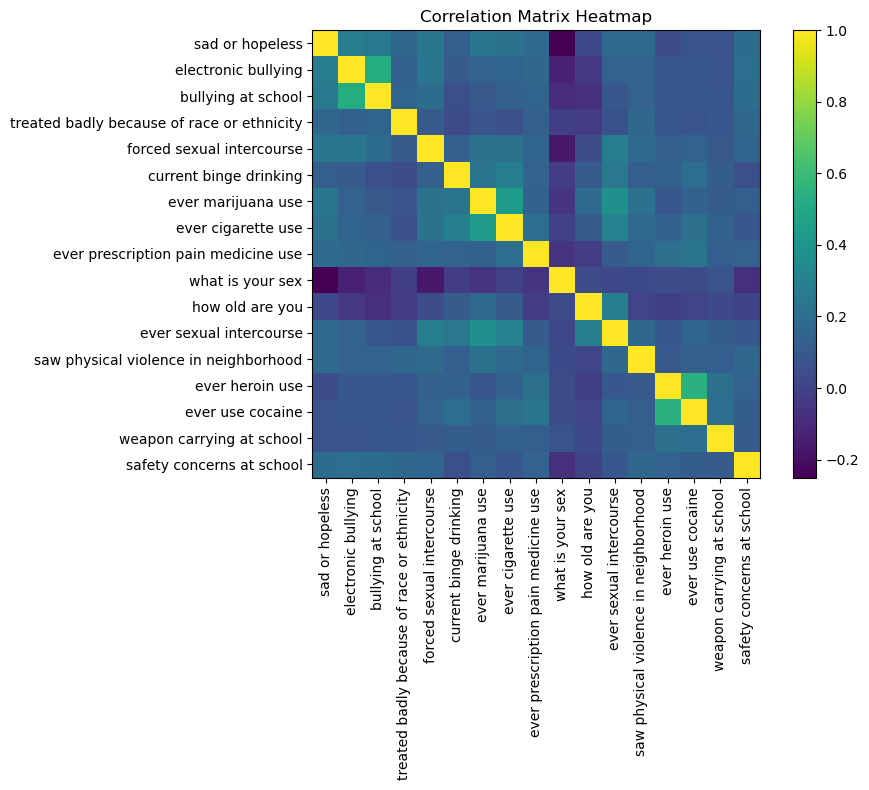

In [18]:
# correlation matrix heatmap
# Copy dataset

df = df_2023.copy()  


# Predictor variables

predictors =  [
    "sad or hopeless",
    "electronic bullying",
    "bullying at school",
    "treated badly because of race or ethnicity",
    "forced sexual intercourse",
    "current binge drinking",
    "ever marijuana use",
    "ever cigarette use",
    "ever prescription pain medicine use",
    "what is your sex",
    "how old are you",
    "ever sexual intercourse",
    "saw physical violence in neighborhood",
    "ever heroin use",
    "ever use cocaine",
    "weapon carrying at school",
    "safety concerns at school"
]


# Build numeric dataset

corr_df = df[predictors].apply(pd.to_numeric, errors="coerce")


# Compute correlation matrix

corr_matrix = corr_df.corr()

# Display numeric matrix
# vprint("Correlation Matrix:")
# print(corr_matrix)


# Plot heatmap with matplotlib

plt.figure(figsize=(10, 8))

plt.imshow(corr_matrix, cmap="viridis")
plt.colorbar()

plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()



The correlation matrix heatmap indicates that most predictors in the dataset exhibit relatively low pairwise correlations, suggesting that multicollinearity is not a concern for the logistic regression model. This observation aligns with earlier Variance Inflation Factor (VIF) results, which showed that all predictors were well below the traditional multicollinearity thresholds. 

The darker squares in most areas of the heatmap signify weak or near-zero correlations among variables such as substance use, bullying, demographic factors, and exposure to community violence. A few moderate correlations are present, primarily among substance-use-related items (e.g., marijuana, cigarettes, prescription pain medication, and cocaine), as well as between bullying-related variables and emotional distress (e.g., feeling "sad or hopeless"). However, none of these correlation levels would distort the model estimates. 

In summary, the heatmap supports the conclusion that each predictor provides distinct information, reinforcing the validity of including all variables in both the regression and chi-square analyses.

#### Mediation Insight and Alignment With Prior Research

The logistic regression analysis revealed that feeling "sad or hopeless" was the strongest predictor of suicidal thoughts in 2023. However, when this variable was excluded from the model, the effect sizes of several upstream risk factors—such as forced sexual intercourse, bullying, discrimination, exposure to neighborhood violence, and substance use—increased significantly. This pattern indicates that these experiences do not operate independently; rather, they primarily influence suicide risk indirectly by contributing to chronic feelings of sadness and hopelessness. This finding aligns with existing mental health research, which recognizes persistent hopelessness as a key mediator between traumatic or stressful experiences and suicidal ideation (Beck et al., 1975; Klonsky et al., 2016). The comparison between the models supports a pathway-based interpretation: adverse experiences → emotional hopelessness → suicidal thoughts. Understanding this mediating role underscores the importance of preventing upstream harms (such as bullying and sexual violence) and providing timely mental health interventions that address depressive symptoms before they escalate to suicidal thinking.

In [19]:
# Run without Sad/hopeless


predictors_A = [
    "sad or hopeless",
    "electronic bullying",
    "bullying at school",
    "treated badly because of race or ethnicity",
    "forced sexual intercourse",
    "current binge drinking",
    "ever marijuana use",
    "ever cigarette use",
    "ever prescription pain medicine use",
    "what is your sex",
    "how old are you",
    "ever sexual intercourse",
    "saw physical violence in neighborhood",
    "ever heroin use",
    "ever use cocaine",
    "weapon carrying at school",
    "safety concerns at school"
]

predictors_B = [col for col in predictors_A if col != "sad or hopeless"]

# ---------------------------------------------
# CLEAN FULL DATASET FOR MODEL A
# ---------------------------------------------
dfA = df[predictors_A + ["considered suicide"]].copy()

# convert everything to numeric
dfA = dfA.apply(pd.to_numeric, errors="coerce")

# drop rows with NA
dfA = dfA.dropna()

yA = dfA["considered suicide"].astype(int)
XA = sm.add_constant(dfA[predictors_A].astype(float))

# fit model A
model_A = sm.Logit(yA, XA).fit(disp=False)

OR_A = pd.DataFrame({
    "Variable": model_A.params.index,
    "OR_with_sad": np.exp(model_A.params)
}).drop(index="const", errors="ignore")

# ---------------------------------------------
# CLEAN FULL DATASET FOR MODEL B
# ---------------------------------------------
dfB = df[predictors_B + ["considered suicide"]].copy()

dfB = dfB.apply(pd.to_numeric, errors="coerce")
dfB = dfB.dropna()

yB = dfB["considered suicide"].astype(int)
XB = sm.add_constant(dfB[predictors_B].astype(float))

# fit model B
model_B = sm.Logit(yB, XB).fit(disp=False)

OR_B = pd.DataFrame({
    "Variable": model_B.params.index,
    "OR_without_sad": np.exp(model_B.params)
}).drop(index="const", errors="ignore")

# ---------------------------------------------
# MERGE TABLES
# ---------------------------------------------
comparison = OR_A.merge(OR_B, on="Variable", how="outer")
comparison = comparison.round(3)
comparison


,Variable,OR_with_sad,OR_without_sad
0,bullying at school,1.537,1.881
1,current binge drinking,1.073,1.100
2,electronic bullying,1.383,1.640
3,ever cigarette use,1.411,1.636
4,ever heroin use,0.689,0.584
5,ever marijuana use,1.338,1.649
6,ever prescription pain medicine use,1.806,2.086
7,ever sexual intercourse,1.064,1.162
8,ever use cocaine,1.430,1.236
9,forced sexual intercourse,2.055,2.418


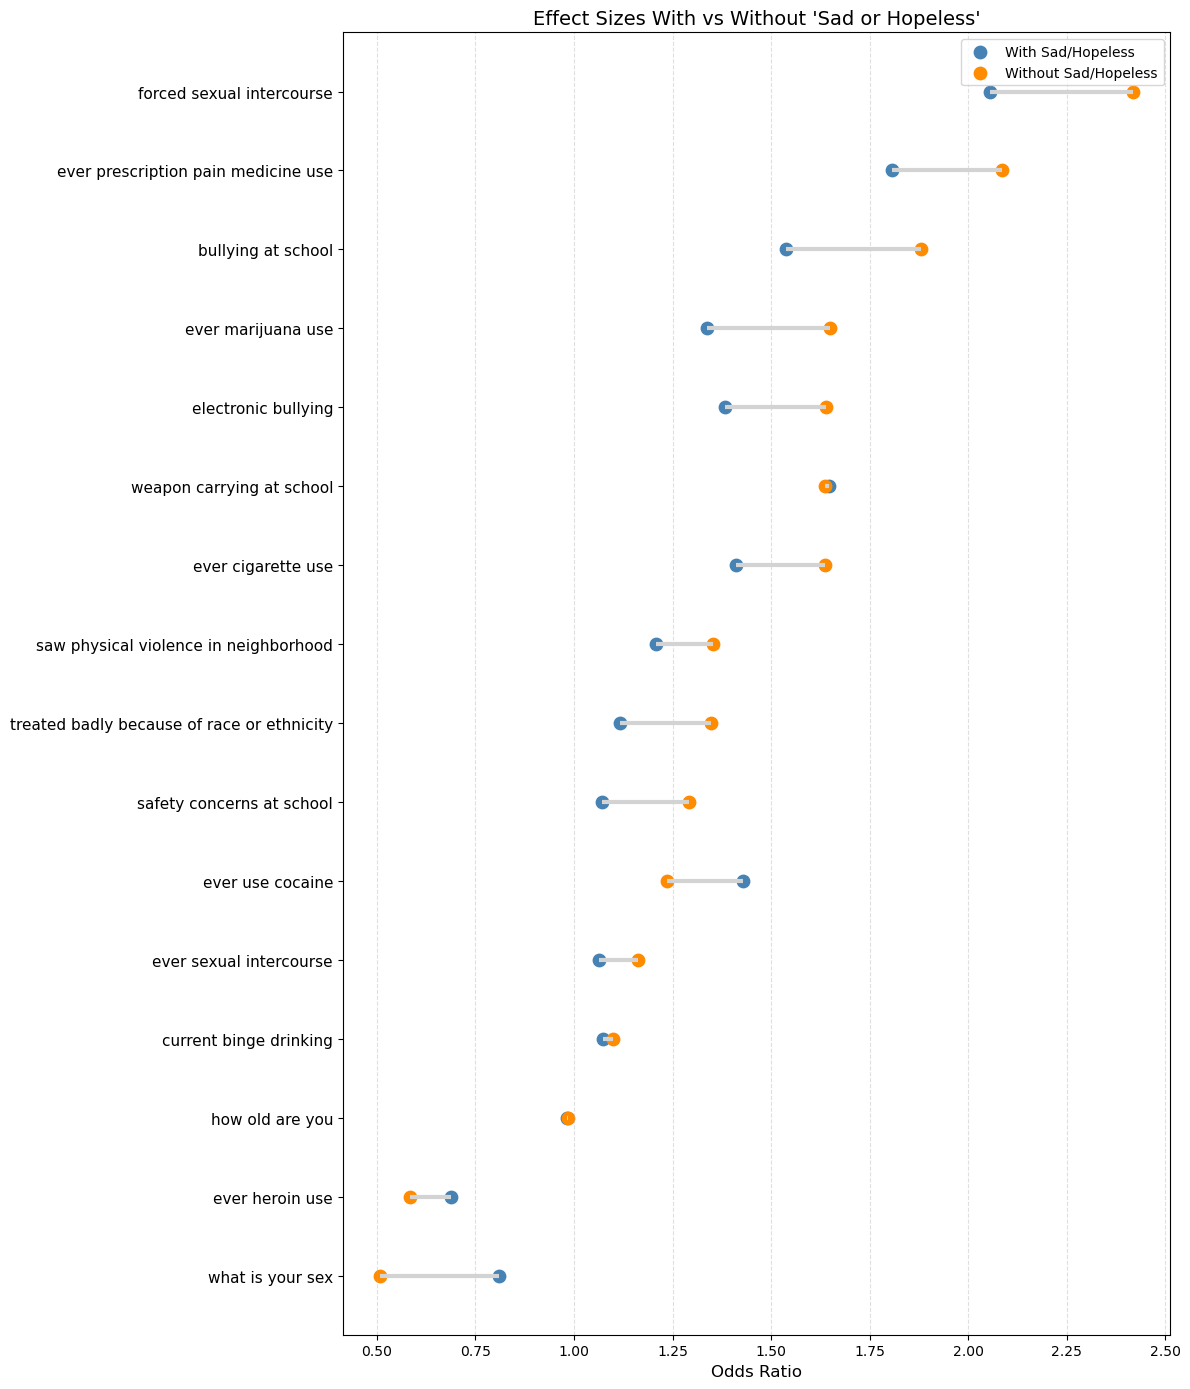

In [20]:
import matplotlib.pyplot as plt
import numpy as np


# Copy and prepare data
plot_df = comparison.dropna().copy()

# Set variable names as index for correct plotting
plot_df.index = plot_df["Variable"]

# Sort for visual clarity
plot_df = plot_df.sort_values("OR_without_sad")

# Y-axis positions
y_pos = np.arange(len(plot_df))

plt.figure(figsize=(12, 14))

# Draw connecting lines
plt.hlines(y=y_pos,
           xmin=plot_df["OR_with_sad"],
           xmax=plot_df["OR_without_sad"],
           color="lightgray",
           linewidth=3)

# OR with sadness
plt.scatter(plot_df["OR_with_sad"],
            y_pos,
            color="steelblue",
            s=80,
            label="With Sad/Hopeless")

# OR without sadness
plt.scatter(plot_df["OR_without_sad"],
            y_pos,
            color="darkorange",
            s=80,
            label="Without Sad/Hopeless")

# Use predictor names instead of numbers
plt.yticks(y_pos, plot_df.index, fontsize=11)

plt.xlabel("Odds Ratio", fontsize=12)
plt.title("Effect Sizes With vs Without 'Sad or Hopeless'", fontsize=14)
plt.legend()
plt.grid(axis="x", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()



The results of this analysis highlight an important distinction between direct predictors of suicidal ideation and the emotional pathways through which these predictors influence thoughts of suicide. In the logistic regression model that included all variables, feelings of sadness or hopelessness emerged as the strongest predictor of suicidal thoughts, significantly surpassing the impact of any other factor. However, when this variable was excluded from the model, the effect sizes of several contributing factors—such as bullying, electronic harassment, forced sexual intercourse, discrimination, exposure to neighborhood violence, and various forms of substance use—substantially increased. This change suggests that these adverse experiences likely affect thoughts of suicide indirectly by contributing to persistent feelings of sadness and hopelessness.

This interpretation aligns with established psychological models in which hopelessness serves as a key mediator linking trauma or chronic stress to suicidal thoughts (e.g., Beck’s Hopelessness Theory and subsequent research by Klonsky and May). 

In practical terms, the findings indicate a pathway that can be summarized as follows:  
adverse experiences → increased hopelessness → suicidal thoughts.

Recognizing this mediating relationship is crucial because it highlights that effective prevention must address both ends of the pathway: (1) reducing exposure to upstream harms such as bullying and violence, and (2) providing timely mental health support that targets hopelessness before it escalates into a risk of suicide.